In [1]:
!python -m spacy download en_core_web_sm

[!] Skipping model package dependencies and setting `--no-deps`. You don't seem
to have the spaCy package itself installed (maybe because you've built from
source?), so installing the model dependencies would cause spaCy to be
downloaded, which probably isn't what you want. If the model package has other
dependencies, you'll have to install them manually.
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
from tqdm import tqdm

import spacy
import en_core_web_sm


# load the dataset
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# load spaCy's language model
#nlp = spacy.load('en_core_web_sm')
nlp = en_core_web_sm.load()
print(nlp.pipe_names)

['tagger', 'parser', 'ner']


In [3]:
nlp.disable_pipes(["ner"])
print(nlp.pipe_names)

['tagger', 'parser']


In [4]:
# preprocessing
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def preprocess(text):
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
    return text

newsgroups.data = [preprocess(text) for text in tqdm(newsgroups.data)]

100%|██████████| 18846/18846 [05:36<00:00, 56.03it/s] 


In [5]:
!pip install gensim

In [6]:
# vectorization

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
# import torch
# from transformers import BertModel, BertTokenizer

class Vectorizer:
    def __init__(self, method, **kwargs):
        self.method = method
        self.kwargs = kwargs
        # self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        # self.model = BertModel.from_pretrained('bert-base-uncased')

    def fit_transform(self, data):
        if self.method == 'count':
            vectorizer = CountVectorizer(**self.kwargs)
            return vectorizer.fit_transform(data)
        elif self.method == 'tfidf':
            vectorizer = TfidfVectorizer(**self.kwargs)
            return vectorizer.fit_transform(data)
        elif self.method == 'word2vec':
            model = Word2Vec(data, **self.kwargs)
            return model
        elif self.method == 'doc2vec':
            tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
            model = Doc2Vec(tagged_data, **self.kwargs)
            return model
        else:
             raise ValueError("Invalid method. Choose 'count', 'tfidf', 'word2vec', or 'doc2vec'.")
        # elif self.method == 'bert':
        #     input_ids = torch.tensor([self.tokenizer.encode(text, add_special_tokens=True) for text in data])
        #     with torch.no_grad():
        #         last_hidden_states = self.model(input_ids)[0]
        #     return last_hidden_states.numpy()
        # else:
        #     raise ValueError("Invalid method. Choose 'count', 'tfidf', 'word2vec', 'doc2vec' or 'bert'.")

# vectorizer = Vectorizer('bert')
#vectorizer = Vectorizer('tfidf', min_df=2, max_df=0.9)
vectorizer = Vectorizer('tfidf')
vectors = vectorizer.fit_transform(newsgroups.data)

In [7]:
# dimensionality reduction

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

class DimensionalityReducer:
    def __init__(self, method, n_components):
        self.method = method
        self.n_components = n_components

    def fit_transform(self, data):
        if self.method == 'LDA':
            lda = LatentDirichletAllocation(n_components=self.n_components)
            return lda.fit_transform(data)
        elif self.method == 'LSI':
            svd = TruncatedSVD(n_components=self.n_components)
            return svd.fit_transform(data)
        else:
            raise ValueError("Invalid method. Choose 'LDA' or 'LSI'.")

n_dimensions = 300            
dim_reducer =  DimensionalityReducer("LSI", n_dimensions)           
vectors_reduced = dim_reducer.fit_transform(vectors)

In [10]:
#!pip install hdbscan

In [13]:
# clustering 

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
# from hdbscan import HDBSCAN

class Clusterer:
    def __init__(self, method, **kwargs):
        self.method = method
        self.kwargs = kwargs

    def fit_transform(self, data):
        if self.method == 'kmeans':
            clusterer = KMeans(**self.kwargs)
            return clusterer.fit_predict(data)
        elif self.method == 'agglomerative':
            clusterer = AgglomerativeClustering(**self.kwargs)
            return clusterer.fit_predict(data)
        elif self.method == 'dbscan':
            clusterer = DBSCAN(**self.kwargs)
            return clusterer.fit_predict(data)
        else:
             raise ValueError("Invalid method. Choose 'kmeans', 'agglomerative', or 'dbscan'.")
        # elif self.method == 'hdbscan':
        #     clusterer = HDBSCAN(**self.kwargs)
        #     return clusterer.fit_predict(data)
        # else:
        #     raise ValueError("Invalid method. Choose 'kmeans', 'agglomerative', 'dbscan' or 'hdbscan'.")

clusters = Clusterer('kmeans', n_clusters=20).fit_transform(vectors_reduced)             
#clusters = Clusterer('hdbscan', min_cluster_size=20).fit_transform(vectors_reduced)

In [28]:
!pip install llvmlite --ignore-installed
!pip install umap-learn

  Using cached llvmlite-0.39.1-cp37-cp37m-win_amd64.whl (23.2 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.48.0 requires llvmlite<0.32.0,>=0.31.0dev0, but you have llvmlite 0.39.1 which is incompatible.


  Using cached umap_learn-0.5.3-py3-none-any.whl
  Using cached pynndescent-0.5.8-py3-none-any.whl
  Using cached numba-0.56.4-cp37-cp37m-win_amd64.whl (2.5 MB)
  Attempting uninstall: numba
    Found existing installation: numba 0.48.0
    Uninstalling numba-0.48.0:
      Successfully uninstalled numba-0.48.0


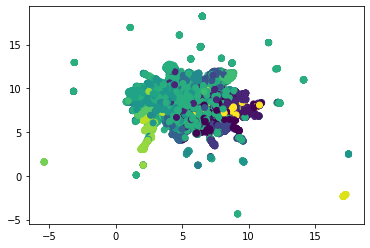

In [29]:
# Viz

# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# tsne = TSNE(n_components=2)
# tsne_vectors = tsne.fit_transform(vectors_reduced)

# plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1], c=clusters)
# plt.show()


import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap.umap_ as umap

class Visualizer:
    def __init__(self, method, **kwargs):
        self.method = method
        self.kwargs = kwargs

    def fit_transform(self, data, labels):
        if self.method == 'scatter':
            plt.scatter(data[:,0], data[:,1], c=labels)
            plt.show()
        elif self.method == 'tsne':
            tsne = TSNE(**self.kwargs)
            reduced_data = tsne.fit_transform(data)
            plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)
            plt.show()
        elif self.method == 'umap':
            reducer = umap.UMAP(**self.kwargs)
            reduced_data = reducer.fit_transform(data)
            plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)
            plt.show()
        else:
            raise ValueError("Invalid method. Choose 'scatter', 'tsne' or 'umap'.")

# Visualizer('tsne', n_components=2).fit_transform(vectors_reduced, clusters)
Visualizer('umap').fit_transform(vectors_reduced, clusters)

In [30]:
from sklearn.metrics import adjusted_rand_score

# evaluation
score = adjusted_rand_score(newsgroups.target, clusters)
print("Adjusted Rand Score:", score)

Adjusted Rand Score: 0.06315843918084454


# Explore number of clusters

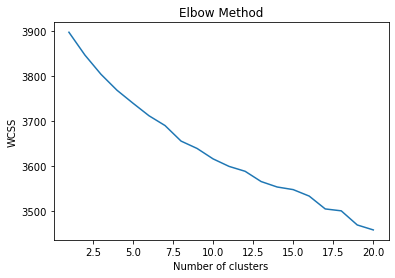

In [31]:
# Elbow method
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(vectors_reduced)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

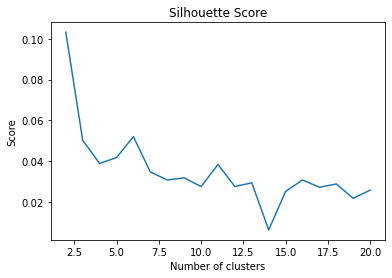

In [32]:
# silhouette score
from sklearn.metrics import silhouette_score

sil = []
for i in range(2, 21):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    pred_i = kmeans.fit_predict(vectors_reduced)
    sil.append(silhouette_score(vectors_reduced, pred_i))

plt.plot(range(2, 21), sil)
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.show()

In [33]:
!pip install --upgrade gap-stat
!pip install gapstat-rs

In [34]:
# Gap statistic
from sklearn.cluster import KMeans
from gap_statistic import OptimalK
import numpy as np

optimalK = OptimalK(parallel_backend='rust')
n_clusters = optimalK(vectors_reduced, cluster_array=np.arange(1, 21))

In [35]:
n_clusters

10

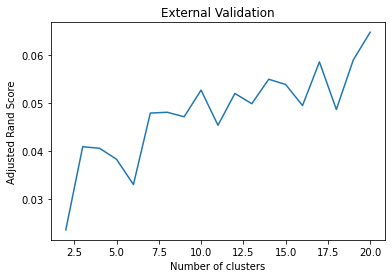

In [36]:
# external validation

from sklearn.metrics import adjusted_rand_score

scores = []
for i in range(2, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    clusters = kmeans.fit_predict(vectors_reduced)
    score = adjusted_rand_score(newsgroups.target, clusters)
    scores.append(score)

plt.plot(range(2, 21), scores)
plt.title('External Validation')
plt.xlabel('Number of clusters')
plt.ylabel('Adjusted Rand Score')
plt.show()

# Plotting alternative clusterings

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


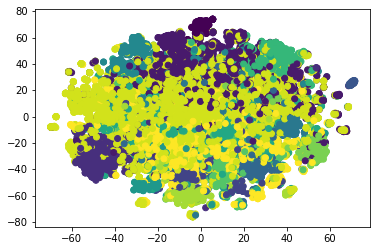

In [38]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=16)
km.fit(vectors_reduced)
clusters = km.predict(vectors_reduced)


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
tsne_vectors = tsne.fit_transform(vectors_reduced)

plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1], c=clusters)
plt.show()